In [1]:
from datetime import datetime

import itk
import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
from scipy.interpolate import UnivariateSpline
from torch.utils.data import DataLoader, Dataset


In [2]:
# globals
patch_size = 16
patch_depth = 7

In [3]:
def add_tube_to_patch(patch, patch_size, tube_i_range, tube_r_range):
    tube_start_x = np.random.uniform(0.1, 0.9) * patch_size[0]
    tube_start_y = np.random.uniform(0.1, 0.9) * patch_size[1]
    tube_start_r = np.random.uniform(tube_r_range[0], tube_r_range[1])
    tube_mid_x = np.random.uniform(0.3, 0.7) * patch_size[0]
    tube_mid_y = np.random.uniform(0.3, 0.7) * patch_size[1]
    tube_mid_r = np.random.uniform(tube_r_range[0], tube_r_range[1])
    tube_end_x = np.random.uniform(0.1, 0.9) * patch_size[0]
    tube_end_y = np.random.uniform(0.1, 0.9) * patch_size[1]
    tube_end_r = np.random.uniform(tube_r_range[0], tube_r_range[1])
    tube_extent = np.random.uniform(0, 1)
    tube_terminate = tube_extent < 0.1
    if not tube_terminate:
        tube_extent = 1.0
    else:
        tube_extent = 0.51 + 0.4 * np.random.uniform(0, 1)

    tube_i = (
        np.random.uniform(tube_i_range[0], tube_i_range[1])
    )

    if np.random.uniform(0, 1) < 0.5:
        tube_ct = True
    else:
        tube_ct = False

    tube_x_spline = UnivariateSpline([0.0, 0.5, 1.0], [tube_start_x, tube_mid_x, tube_end_x], k=2)
    tube_y_spline = UnivariateSpline([0.0, 0.5, 1.0], [tube_start_y, tube_mid_y, tube_end_y], k=2)
    tube_r_spline = UnivariateSpline([0.0, 0.5, 1.0], [tube_start_r, tube_mid_r, tube_end_r], k=2)
    for i,t in enumerate(np.linspace(0.0, 1.0*tube_extent, patch_size[2])):
        tube_x = tube_x_spline(t)
        tube_y = tube_y_spline(t)
        tube_r = tube_r_spline(t)
        if i >= patch_size[2] // 2 and i <= (patch_size[2] // 2 + 1):
            tube_center_x = tube_x
            tube_center_y = tube_y
            tube_center_r = tube_r
            tube_center_i = tube_i
        z = np.clip(int(t * patch_size[2]), 0, patch_size[2] - 1)
        for rx in range(int(-tube_r - 0.5), int(tube_r + 0.5)):
            for ry in range(int(-tube_r - 0.5), int(tube_r + 0.5)):
                if rx**2 + ry**2 < tube_r**2:
                    x = np.clip(int(tube_x + rx), 0, patch_size[0] - 1)
                    y = np.clip(int(tube_y + ry), 0, patch_size[1] - 1)
                    if tube_ct:
                        patch[z, y, x] = tube_i
                    else:
                        patch[z, y, x] = tube_i * (1 - (rx**2 + ry**2) / (1.5 * tube_r) ** 2)

    return tube_center_x, tube_center_y, tube_center_r, tube_center_i, tube_terminate

In [4]:
def add_noise_to_patch(
    patch,
    patch_size,
    noise_point_mean,
    noise_point_stddev,
    noise_edge_intensity_range,
    noise_edge_spread_range,
    noise_slope_intensity_range,
):
    noise_point_mean = np.random.uniform(0, noise_point_mean)
    noise_point_stddev = np.random.uniform(0.01, noise_point_stddev)

    noise_edge_intensity = (
        np.random.uniform(noise_edge_intensity_range[0], noise_edge_intensity_range[1])
    )
    noise_edge_spread = np.random.uniform(noise_edge_spread_range[0], noise_edge_spread_range[1])
    noise_edge_position = np.empty(3)
    noise_edge_position[0] = np.random.uniform(0, 1) * patch_size[0]
    noise_edge_position[1] = np.random.uniform(0, 1) * patch_size[1]
    noise_edge_position[2] = np.random.uniform(0, 1) * patch_size[2]
    noise_edge_orientation = np.empty(3)
    noise_edge_orientation[0] = np.random.uniform(-1, 1)
    noise_edge_orientation[1] = np.random.uniform(-1, 1)
    noise_edge_orientation[2] = np.random.uniform(-1, 1)
    noise_edge_orientation = noise_edge_orientation / np.linalg.norm(noise_edge_orientation)

    noise_slope_intensity = (
        np.random.uniform(noise_slope_intensity_range[0], noise_slope_intensity_range[1])
    )
    noise_slope_position = np.empty(3)
    noise_slope_position[0] = np.random.uniform(0, 1) * patch_size[0]
    noise_slope_position[1] = np.random.uniform(0, 1) * patch_size[1]
    noise_slope_position[2] = np.random.uniform(0, 1) * patch_size[2]
    noise_slope_orientation = np.empty(3)
    noise_slope_orientation[0] = np.random.uniform(-1, 1)
    noise_slope_orientation[1] = np.random.uniform(-1, 1)
    noise_slope_orientation[2] = np.random.uniform(-1, 1)
    noise_slope_orientation = noise_slope_orientation / np.linalg.norm(noise_slope_orientation)

    for x in range(0, patch_size[0]):
        for y in range(0, patch_size[1]):
            for z in range(0, patch_size[2]):
                point_noise = np.random.normal(noise_point_mean, noise_point_stddev)
                dist_from_edge = (
                    (x - noise_edge_position[0]) * noise_edge_orientation[0]
                    + (y - noise_edge_position[1]) * noise_edge_orientation[1]
                    + (z - noise_edge_position[2]) * noise_edge_orientation[2]
                )
                edge_noise = noise_edge_intensity / (
                    1 + np.exp(-dist_from_edge / noise_edge_spread)
                )
                dist_along_slope = (
                    (x - noise_slope_position[0]) * noise_slope_orientation[0]
                    + (y - noise_slope_position[1]) * noise_slope_orientation[1]
                    + (z - noise_slope_position[2]) * noise_slope_orientation[2]
                )
                slope_noise = (
                    noise_slope_intensity
                    * dist_along_slope
                    / (patch_size[0] + patch_size[1] + patch_size[2])
                )
                patch[z, y, x] += point_noise + edge_noise + slope_noise

    patch_max = np.max(patch)
    patch = patch / patch_max

In [5]:
def gen_training_patch(p_size, p_depth):
    patch_size = [p_size, p_size, p_depth]
    tube_intensity_range = [0.2, 0.9]
    tube_r_range = [p_size * 0.1, p_size * 0.4]
    noise_point_mean = 0.5
    noise_point_stddev = 0.4
    noise_edge_intensity_range = [0.0, 0.25]
    noise_edge_spread_range = [0.1, 4]
    noise_slope_intensity_range = [0.0, 0.25]

    patch = np.zeros(patch_size[::-1], dtype=np.float32)

    tube_branch = np.random.uniform(0, 1) > 0.75
    if tube_branch:
        add_tube_to_patch(patch, patch_size, tube_intensity_range, tube_r_range)
        patch *= 0.25

    tube_center = [0, 0]
    tube_center[0], tube_center[1], tube_radius, tube_intensity, tube_terminate = add_tube_to_patch(
        patch, patch_size, tube_intensity_range, tube_r_range
    )

    add_noise_to_patch(
        patch,
        patch_size,
        noise_point_mean,
        noise_point_stddev,
        noise_edge_intensity_range,
        noise_edge_spread_range,
        noise_slope_intensity_range,
    )

    return patch, tube_center, tube_terminate, tube_radius, tube_intensity, tube_branch

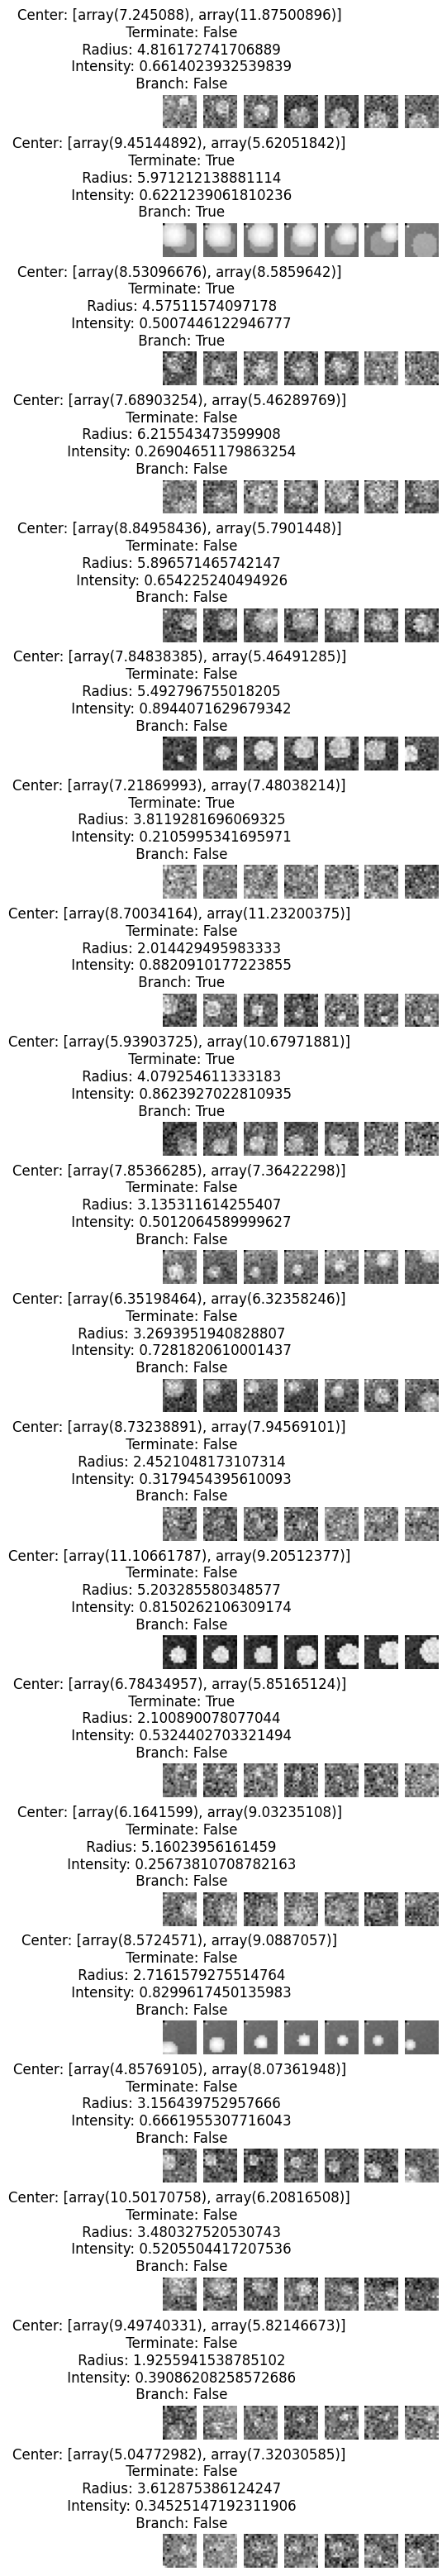

In [6]:
plt.figure(0, [10, 40])
num_patches = 20
for i in range(num_patches):
    data = gen_training_patch(patch_size, patch_depth)
    for s in range(patch_depth):
        plt.subplot(num_patches, patch_size, i * patch_size + s + 1)
        tmp = data[0][s, :, :]
        tmp[0, 0] = 0
        tmp[1, 1] = 1
        plt.imshow(data[0][s, :, :], cmap='gray')
        if s == 0:
            plt.title(
                "Center: "
                + str(data[1])
                + "\n Terminate: "
                + str(data[2])
                + "\n Radius: "
                + str(data[3])
                + "\n Intensity: "
                + str(data[4])
                + "\n Branch: "
                + str(data[5])
            )
        plt.axis('off')
plt.show()

In [7]:
def get_training_data(patch_size, patch_depth):
    data = gen_training_patch(patch_size, patch_depth)

    patch = data[0]
    center = data[1]
    terminate = data[2]
    radius = data[3]
    intensity = data[4]

    # patch = np.expand_dims(patch, axis=0) # uncomment to make a 3D patch (rather than
    #     multi-channel 2D)
    patch = patch.astype(np.float32)
    patch = torch.from_numpy(patch)

    center = np.array(center)
    center = center.astype(np.float32)
    center = torch.from_numpy(center)

    terminate = np.array([terminate])
    terminate = terminate.astype(np.float32)
    terminate = torch.from_numpy(terminate)

    radius = np.array([radius])
    radius = radius.astype(np.float32)
    radius = torch.from_numpy(radius)

    intensity = np.array([intensity])
    intensity = intensity.astype(np.float32)
    intensity = torch.from_numpy(intensity)

    return patch, center, terminate, radius, intensity


class TubeDataset(Dataset):
    def __init__(self, patch_size, patch_depth):
        self.patch_size = patch_size
        self.patch_depth = patch_depth

    def __len__(self):
        return 1000

    def __getitem__(self, _):
        return get_training_data(self.patch_size, self.patch_depth)


dataset = TubeDataset(patch_size, patch_depth)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
# Check if GPU is available and move the model to GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.resnet18(spatial_dims=2, n_input_channels=patch_depth, num_classes=5).to(device)

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)


In [8]:

if True:
    # Training loop with GPU support
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for patches, centers, terminates, radii, intensities in dataloader:
            patches, centers, terminates, radii, intensities = (
                patches.to(device),
                centers.to(device),
                terminates.to(device),
                radii.to(device),
                intensities.to(device),
            )
            optimizer.zero_grad()
            outputs = model(patches)
            targets = torch.cat((centers, terminates, radii, intensities), dim=1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")
    date = datetime.now().strftime("%Y.%m.%d")
    torch.save(model, f'vessel_seg_resnet18_{date}.pth')

Epoch 1/100, Loss: 24.937808307647707
Epoch 2/100, Loss: 17.92176131057739
Epoch 3/100, Loss: 12.583297006607056
Epoch 4/100, Loss: 8.7414760389328
Epoch 5/100, Loss: 5.81211303806305
Epoch 6/100, Loss: 3.86616951751709
Epoch 7/100, Loss: 2.812264807462692
Epoch 8/100, Loss: 2.2398065090179444
Epoch 9/100, Loss: 1.827897545337677
Epoch 10/100, Loss: 1.68491118144989
Epoch 11/100, Loss: 1.6150634317398072
Epoch 12/100, Loss: 1.522225932598114
Epoch 13/100, Loss: 1.4296356410980224
Epoch 14/100, Loss: 1.4861961458921433
Epoch 15/100, Loss: 1.5307690143585204
Epoch 16/100, Loss: 1.3544506739377975
Epoch 17/100, Loss: 1.3725985642671585
Epoch 18/100, Loss: 1.3403521998524666
Epoch 19/100, Loss: 1.2101972755789756
Epoch 20/100, Loss: 1.212047006726265
Epoch 21/100, Loss: 1.1763705781698226
Epoch 22/100, Loss: 1.193912346482277
Epoch 23/100, Loss: 1.2264495832920075
Epoch 24/100, Loss: 1.168056521654129
Epoch 25/100, Loss: 1.1817967422008515
Epoch 26/100, Loss: 1.2128807158470154
Epoch 27/10

In [9]:
date = datetime.now().strftime("%Y.%m.%d")
model = torch.load(f'vessel_seg_resnet18_{date}.pth', weights_only=False)

In [19]:
def extract_patch(image, x, r, t, patch_size=16, patch_depth=7):
    n1 = np.array([t[1], -t[0], t[2]])
    if n1[0] == 0 and n1[1] == 0:
        n1 = np.array([t[2], -t[0], t[1]])
    n1 = n1 / np.linalg.norm(n1)
    n2 = np.cross(t, n1)
    n2 = n2 / np.linalg.norm(n2)

    image_spacing = image.GetSpacing()[0]

    patch_r = 3
    patch_spacing = r / (patch_r * image_spacing)
    if patch_spacing < image_spacing:
        patch_spacing = image_spacing

    print("patch_r =", patch_r)
    print("image_spacing =", image_spacing)
    print("patch_spacing =", patch_spacing)

    interp = itk.BSplineInterpolateImageFunction.New(image)
    patch = np.empty((patch_depth, patch_size, patch_size)).astype(np.float32)
    for iz in range(patch_depth):
        pz = (iz - patch_depth / 2) * patch_spacing
        for iy in range(patch_size):
            py = (iy - patch_size / 2) * patch_spacing
            for ix in range(patch_size):
                px = (ix - patch_size / 2) * patch_spacing
                pnt = x + np.multiply(px, n1) + np.multiply(py, n2) + np.multiply(pz, t)
                cindx = image.TransformPhysicalPointToIndex(pnt)
                v = interp.EvaluateAtContinuousIndex(cindx)
                patch[iz, iy, ix] = v

    return patch, patch_spacing, n1, n2

    # t_step = patch_spacing * patch_size / 4
    # new_x = x + t*t_step
    # new_t = (new_x - x) / np.linalg.norm(new_x - x)


def step(image, model, x, r, t):
    patch_size = 16
    patch_depth = 7
    patch, patch_spacing, n1, n2 = extract_patch(image, x, r, t, patch_size, patch_depth)
    patch_img = itk.GetImageFromArray(patch)
    itk.imwrite(patch_img, f"patch{x[0]}.mha")

    patch = np.expand_dims(patch, axis=0)
    patch = torch.from_numpy(patch).to('cuda:0')

    model.eval()
    with torch.no_grad():
        output = model(patch)

    t_step = patch_spacing
    n1_step = (output[0][0].item() - 0.5) * patch_size * patch_spacing
    n2_step = (output[0][1].item() - 0.5) * patch_size * patch_spacing

    x_step = t * t_step + n1 * n1_step + n2 * n2_step
    print("x_step =", x_step)
    new_x = x + x_step

    term = output[0][2].item() > 0.5

    new_r = output[0][3].item() * patch_size * patch_spacing
    print("new_r =", output)
    new_r = (r + new_r) / 2

    new_t = (t + x_step / np.linalg.norm(x_step)) / 2
    new_t = new_t / np.linalg.norm(new_t)

    prob = output[0][4].item()

    return new_x, new_r, new_t, term, prob, patch.to('cpu').detach().numpy()

In [20]:
img = itk.imread('Branch.n020.mha')

img_arr = itk.GetArrayFromImage(img).astype(np.float32)
img_arr /= np.max(img_arr)

img_norm = itk.GetImageFromArray(img_arr)
img_norm.CopyInformation(img)

In [21]:
patch = extract_patch(img_norm, [50, 50, 50], 1, [1, 0, 0])

patch_r = 3
image_spacing = 1.0
patch_spacing = 1.0


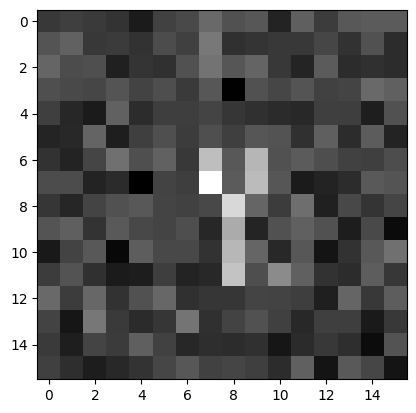

: 

In [ ]:
plt.imshow(patch[0][2, :, :], cmap='gray')
plt.show()

In [ ]:
old_x = np.array([48, 50, 50])
old_t = np.array([1, 0, 0])
old_r = 0.5

patch_list = []
for i in range(20):
    new_x, new_r, new_t, term, prob, patch = step(img_norm, model, old_x, old_r, old_t)
    print(new_x, new_r, new_t)
    old_x = new_x
    old_r = new_r
    old_t = new_t
    patch_list.append(patch)

for i in range(len(patch_list)):
    plt.figure(i)
    plt.imshow(patch_list[i][0, 1, :, :], cmap='gray')
    plt.axis('off')

patch_r = 3
image_spacing = 1.0
patch_spacing = 1.0
x_step = [   1.         -107.13097382 -116.506073  ]
new_r = tensor([[7.1957, 7.7816, 0.2972, 2.4392, 0.5057]], device='cuda:0')